In [47]:
import pandas as pd

training_dataset = pd.read_csv("./dataset/undersampling_dataset_50_2.csv")
training_dataset.drop(columns=['PHI_S'],inplace=True)

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.utils import shuffle
# import pandas as pd

# # Assume dataset_df_updated is your dataframe with 'Lithology_code' and feature columns

# # Define the list of majority classes to undersample
# majority_classes = [65000, 65030, 30000, 70000]  # Ganti dengan kode kelas mayoritas yang sesuai

# # Get class frequencies to understand the initial distribution
# class_counts = training_dataset['Lithology_code'].value_counts()

# # Display initial distribution
# print("Jumlah sampel sebelum undersampling:")
# for cls in class_counts.index:
#     print(f"Kelas {cls}: {class_counts[cls]} sampel")

# # Identify minority classes (all classes not in majority_classes)
# minority_classes = [cls for cls in class_counts.index if cls not in majority_classes]

# target_size = 50000

# # Features used for clustering
# features_for_clustering = training_dataset.columns.to_list()

# # List to hold the processed dataframes
# df_list = []

# # Process each class group
# for cls, group in training_dataset.groupby('Lithology_code'):
#     if cls in majority_classes and len(group) > target_size:
#         # Perform clustering-based undersampling for majority class es exceeding target_size
#         n_clusters = target_size
#         kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#         group['Cluster'] = kmeans.fit_predict(group[features_for_clustering])
#         # Select one sample per cluster to maintain variation
#         group_undersampled = group.groupby('Cluster').apply(
#             lambda x: x.sample(1, random_state=42)
#         ).reset_index(drop=True)
#         df_list.append(group_undersampled.drop(columns=['Cluster']))
#     else:
#         # Keep all samples for minority classes or majority classes with size <= target_size
#         df_list.append(group)

# # Combine all processed dataframes
# df_balanced = pd.concat(df_list, ignore_index=True)
# df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

# # Display the class distribution after undersampling
# print("\nDistribusi kelas setelah undersampling:")
# print(df_balanced['Lithology_code'].value_counts())

Jumlah sampel sebelum undersampling:
Kelas 65000.0: 144966 sampel
Kelas 30000.0: 43855 sampel
Kelas 65030.0: 20284 sampel
Kelas 70000.0: 16767 sampel
Kelas 80000.0: 8245 sampel
Kelas 70032.0: 5343 sampel
Kelas 88000.0: 3919 sampel
Kelas 99000.0: 3824 sampel
Kelas 74000.0: 1109 sampel
Kelas 90000.0: 1027 sampel
Kelas 86000.0: 920 sampel
Kelas 93000.0: 141 sampel

Distribusi kelas setelah undersampling:
Lithology_code
65000.0    50000
30000.0    43855
65030.0    20284
70000.0    16767
80000.0     8245
70032.0     5343
88000.0     3919
99000.0     3824
74000.0     1109
90000.0     1027
86000.0      920
93000.0      141
Name: count, dtype: int64


In [7]:
df_balanced.to_csv("./dataset/undersampling_dataset_50_2.csv",index=False)

In [7]:
from pycaret.classification import *
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (ganti dengan dataset yang sesuai)
data = training_dataset.copy()

# Pisahkan fitur dan target
target_column = "Lithology_code"  # Ganti dengan nama kolom target

# Split dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Setup PyCaret
clf = setup(train_data, target=target_column, normalize=True, session_id=42)

# Compare models and find the best one
best_model = compare_models()

# Evaluate best model on training data
evaluate_model(best_model)

,Description,Value
0,Session id,42
1,Target,Lithology_code
2,Target type,Multiclass
3,Target mapping,"30000.0: 0, 65000.0: 1, 65030.0: 2, 70000.0: 3, 70032.0: 4, 74000.0: 5, 80000.0: 6, 86000.0: 7, 88000.0: 8, 90000.0: 9, 93000.0: 10, 99000.0: 11"
4,Original data shape,"(124347, 13)"
5,Transformed data shape,"(124347, 13)"
6,Transformed train set shape,"(87042, 13)"
7,Transformed test set shape,"(37305, 13)"
8,Numeric features,12
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9681,0.9984,0.9681,0.9682,0.9680,0.9592,0.9592,1.0490
rf,Random Forest Classifier,0.9653,0.9980,0.9653,0.9653,0.9651,0.9555,0.9556,3.7780
xgboost,Extreme Gradient Boosting,0.9614,0.9978,0.9614,0.9614,0.9613,0.9506,0.9506,2.0440
dt,Decision Tree Classifier,0.9359,0.9591,0.9359,0.9360,0.9359,0.9181,0.9181,0.3270
knn,K Neighbors Classifier,0.9348,0.9880,0.9348,0.9348,0.9345,0.9166,0.9166,0.5070
gbc,Gradient Boosting Classifier,0.9030,0.0000,0.9030,0.9028,0.9014,0.8750,0.8756,74.3190
lightgbm,Light Gradient Boosting Machine,0.8428,0.9087,0.8428,0.8482,0.8441,0.7994,0.7997,2.7320
lr,Logistic Regression,0.6762,0.0000,0.6762,0.6417,0.6417,0.5700,0.5769,1.5120
lda,Linear Discriminant Analysis,0.6557,0.0000,0.6557,0.6304,0.6170,0.5432,0.5503,0.0740
svm,SVM - Linear Kernel,0.6469,0.0000,0.6469,0.5963,0.6067,0.5315,0.5395,0.1470


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [8]:
from sklearn.metrics import classification_report

# Evaluate best model on test data
test_predictions = predict_model(best_model, data=test_data)
print("Evaluation on test data:")
# print(test_predictions)

# Measure prediction quality
y_true = test_data[target_column]
y_pred = test_predictions['Lithology_code']
print("Classification Report:")
print(classification_report(y_true, y_pred))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9684,0.9985,0.9684,0.9684,0.9683,0.9596,0.9596


Evaluation on test data:
Classification Report:
              precision    recall  f1-score   support

     30000.0       1.00      1.00      1.00      8813
     65000.0       1.00      1.00      1.00      9885
     65030.0       1.00      1.00      1.00      4147
     70000.0       1.00      1.00      1.00      3343
     70032.0       1.00      1.00      1.00      1034
     74000.0       1.00      1.00      1.00       222
     80000.0       1.00      1.00      1.00      1686
     86000.0       1.00      1.00      1.00       181
     88000.0       1.00      1.00      1.00       789
     90000.0       1.00      1.00      1.00       201
     93000.0       1.00      1.00      1.00        29
     99000.0       1.00      1.00      1.00       757

    accuracy                           1.00     31087
   macro avg       1.00      1.00      1.00     31087
weighted avg       1.00      1.00      1.00     31087



In [10]:
y_pred.value_counts()

Lithology_code
65000.0    9885
30000.0    8813
65030.0    4147
70000.0    3343
80000.0    1686
70032.0    1034
88000.0     789
99000.0     757
74000.0     222
90000.0     201
86000.0     181
93000.0      29
Name: count, dtype: int64

In [11]:
from pycaret.classification import save_model

# Simpan model
save_model(best_model, 'best_model_1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SP', 'GR', 'DTC', 'Y_LOC', 'DRHO',
                                              'RHOB', 'NPHI', 'X_LOC', 'CALI',
                                              'DEPT', 'Vclay', 'NDPD'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               f...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt'

---
## EXTRA TREES CLASSFIER

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [31]:
dataset_full = pd.read_csv("./dataset/ready_training_dataset.csv")
dataset_full.shape

(250400, 13)

In [34]:
dataset_full.drop(columns=['X_LOC','Y_LOC'],inplace=True)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

X = dataset_full.drop(columns=['Lithology_code'])
y = dataset_full['Lithology_code']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train Extra Trees Classifier
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred))
# Perform hyperparameter tuning using GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    ExtraTreesClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use best model for final prediction
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Print final accuracy
final_accuracy = accuracy_score(y_test, y_pred)
print(f'Final accuracy with tuned model: {final_accuracy:.4f}')

Accuracy: 0.9808
Classification Report:
               precision    recall  f1-score   support

     30000.0       0.98      0.98      0.98      8677
     65000.0       0.98      0.99      0.99     29001
     65030.0       0.96      0.93      0.95      4095
     70000.0       0.98      0.94      0.96      3394
     70032.0       0.99      0.98      0.98      1033
     74000.0       0.99      0.82      0.90       227
     80000.0       0.97      0.96      0.96      1654
     86000.0       0.98      0.99      0.99       174
     88000.0       1.00      1.00      1.00       815
     90000.0       0.98      0.94      0.96       202
     93000.0       1.00      1.00      1.00        20
     99000.0       0.98      0.97      0.98       788

    accuracy                           0.98     50080
   macro avg       0.98      0.96      0.97     50080
weighted avg       0.98      0.98      0.98     50080

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estim

In [30]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the model
joblib.dump(model, 'extra_trees_model.pkl')

['extra_trees_model.pkl']

In [ ]:
dataset_full = dataset_full[['NPHI' ,'DEPT' , 'GR' , 'Vclay' , 'SP', 'Lithology_code']]

In [ ]:
from sklearn.preprocessing import StandardScaler

X = dataset_full.drop(columns=['Lithology_code'])
y = dataset_full['Lithology_code']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train Extra Trees Classifier
model = ExtraTreesClassifier(n_estimators=300, random_state=42, min_samples_split = 2, min_samples_leaf = 1, max_depth = None)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.9628
Classification Report:
               precision    recall  f1-score   support

     30000.0       0.96      0.96      0.96      8677
     65000.0       0.97      0.99      0.98     29001
     65030.0       0.93      0.88      0.91      4095
     70000.0       0.96      0.90      0.93      3394
     70032.0       0.97      0.97      0.97      1033
     74000.0       0.96      0.66      0.78       227
     80000.0       0.93      0.91      0.92      1654
     86000.0       0.99      0.95      0.97       174
     88000.0       1.00      0.99      1.00       815
     90000.0       0.95      0.88      0.92       202
     93000.0       0.94      0.80      0.86        20
     99000.0       0.94      0.89      0.92       788

    accuracy                           0.96     50080
   macro avg       0.96      0.90      0.93     50080
weighted avg       0.96      0.96      0.96     50080



In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mendapatkan feature importance
feature_importance = model.feature_importances_

# Membuat DataFrame untuk menampilkan secara lebih rapi
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Urutkan berdasarkan nilai kepentingan fitur
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Cetak nilai feature importance
print(feature_importance_df)

  Feature  Importance
0    NPHI    0.247084
1    DEPT    0.240771
4      SP    0.218758
3   Vclay    0.148505
2      GR    0.144882


In [ ]:
import joblib

# Save the model
joblib.dump(model, 'extra_trees_model.pkl')

Accuracy: 0.9539


TypeError: object of type 'numpy.float64' has no len()

---

In [52]:
df_balanced  = pd.read_csv("./dataset/undersampling_dataset_50.csv")
df_balanced.drop(columns=['RHOB','SP'], inplace=True)
df_balanced

,X_LOC,Y_LOC,DEPT,NPHI,DTC,GR,CALI,Lithology_code
0,483529.78125,6590317.5,1856.118000,0.413756,116.761692,68.089821,12.274452,99000.0
1,444165.68750,6435564.0,2563.007790,0.220407,65.398209,11.922521,12.570300,70032.0
2,449956.81250,6500258.5,2832.345604,0.028278,50.599144,80.928802,12.336000,65030.0
3,442440.43750,6759336.5,3661.138001,0.260660,82.386101,88.519730,8.490198,65000.0
4,515574.43750,6495507.0,1213.974793,0.327166,105.174644,19.124099,18.285646,70032.0
...,...,...,...,...,...,...,...,...
155429,483526.62500,6590320.5,2057.974000,0.180640,84.731209,68.534492,12.195006,70000.0
155430,442443.37500,6759392.0,1298.450001,0.297358,144.449600,43.589630,17.878799,65030.0
155431,515574.43750,6495507.0,1320.526793,0.313288,84.315750,19.893385,18.423449,70032.0
155432,520153.18750,6452287.5,2587.601016,0.039551,67.738098,11.780769,12.209307,88000.0


,Description,Value
0,Session id,42
1,Target,Lithology_code
2,Target type,Multiclass
3,Target mapping,"30000.0: 0, 65000.0: 1, 65030.0: 2, 70000.0: 3, 70032.0: 4, 74000.0: 5, 80000.0: 6, 86000.0: 7, 88000.0: 8, 90000.0: 9, 93000.0: 10, 99000.0: 11"
4,Original data shape,"(124347, 8)"
5,Transformed data shape,"(124347, 8)"
6,Transformed train set shape,"(87042, 8)"
7,Transformed test set shape,"(37305, 8)"
8,Numeric features,7
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9590,0.9977,0.9590,0.9590,0.9588,0.9475,0.9475,0.6630
rf,Random Forest Classifier,0.9553,0.9972,0.9553,0.9552,0.9551,0.9427,0.9428,7.4210
xgboost,Extreme Gradient Boosting,0.9447,0.9961,0.9447,0.9446,0.9445,0.9292,0.9293,1.7230
dt,Decision Tree Classifier,0.9277,0.9540,0.9277,0.9279,0.9277,0.9077,0.9077,0.4610
knn,K Neighbors Classifier,0.9244,0.9838,0.9244,0.9243,0.9241,0.9033,0.9033,0.1680
gbc,Gradient Boosting Classifier,0.8872,0.0000,0.8872,0.8863,0.8853,0.8547,0.8553,51.3080
lightgbm,Light Gradient Boosting Machine,0.8419,0.9112,0.8419,0.8473,0.8430,0.7984,0.7988,2.2830
qda,Quadratic Discriminant Analysis,0.6569,0.0000,0.6569,0.6795,0.6228,0.5545,0.5613,0.0680
lr,Logistic Regression,0.6373,0.0000,0.6373,0.5611,0.5814,0.5129,0.5239,1.1970
lda,Linear Discriminant Analysis,0.6083,0.0000,0.6083,0.5403,0.5541,0.4777,0.4866,0.0570


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7674,0.9675,0.7674,0.7939,0.7357,0.6885,0.7003
1,0.7698,0.9677,0.7698,0.7973,0.7382,0.6917,0.7034
2,0.7742,0.9685,0.7742,0.8018,0.7429,0.6981,0.7095
3,0.7687,0.9669,0.7687,0.7963,0.7381,0.6905,0.7019
4,0.7761,0.9683,0.7761,0.8024,0.7470,0.7004,0.7122
5,0.7711,0.9666,0.7711,0.7980,0.7428,0.6938,0.7055
6,0.7756,0.9709,0.7756,0.8033,0.7434,0.6996,0.7117
7,0.7723,0.9683,0.7723,0.7984,0.7413,0.6951,0.7070
8,0.7722,0.9688,0.7722,0.8022,0.7414,0.6947,0.7068


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9654,0.9984,0.9654,0.9653,0.9653,0.9558,0.9558


               X_LOC      Y_LOC         DEPT      NPHI         DTC  \
154035  479887.75000  6641113.5  1408.586060  0.492505  132.554260   
136062  449956.62500  6500265.5  2227.689697  0.220226   88.395157   
112579  475846.09375  6621550.0  1082.536011  0.346717  150.777405   
50870   476768.21875  6523588.5  1670.902344  0.321127  124.633934   
131231  479888.37500  6641111.0   766.234009  0.224476  141.117996   
...              ...        ...          ...       ...         ...   
68808   520153.18750  6452287.5  3193.777100  0.050000   72.642723   
114180  497355.90625  6737312.0  1064.725952  0.360027  143.280167   
93581   480019.46875  6515757.0  1453.780029  0.503353  166.206879   
135260  449947.46875  6500260.5  1280.273560  0.430647  140.676941   
82795   444160.59375  6435557.5  2296.399902  0.159106   75.040062   

                GR       CALI  Lithology_code  prediction_label  \
154035   50.384632  18.515604         65000.0             65000   
136062   27.704605  12.10

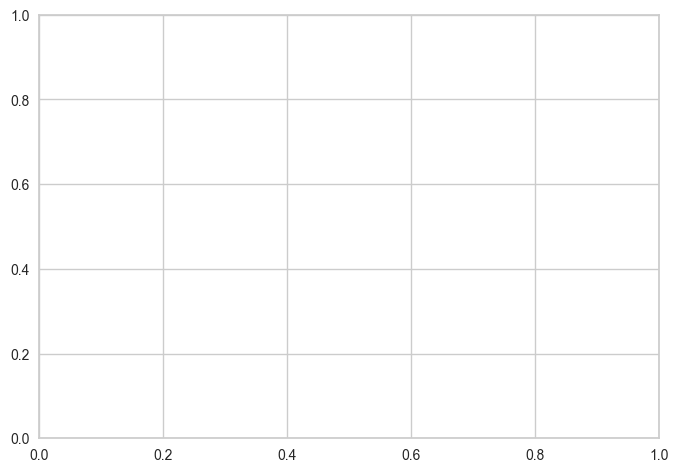

In [ ]:
from pycaret.classification import *
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (ganti dengan dataset yang sesuai)
data = df_balanced.copy()

# Pisahkan fitur dan target
target_column = "Lithology_code"  # Ganti dengan nama kolom target

# Split dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Setup PyCaret
clf = setup(train_data, target=target_column, normalize=True, session_id=42)

# Compare models and find the best one
best_model = compare_models()

# Hyperparameter tuning
tuned_model = tune_model(best_model)

# Evaluate tuned model
evaluate_model(tuned_model)

# Finalize the model (optional, jika ingin digunakan untuk prediksi lebih lanjut)
final_model = finalize_model(tuned_model)

# Predict on test data
predictions = predict_model(final_model, data=test_data)

# Display predictions
print(predictions)

In [56]:
print(tuned_model.get_params())


{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [58]:

# Save the final model
save_model(final_model, "final_lithology_model")

print("Model saved successfully!")

Transformation Pipeline and Model Successfully Saved
Model saved successfully!


In [1]:
import pandas as pd

df = pd.read_csv("./test_dataset/result_cleaning2.csv")
df

,X_LOC,Y_LOC,DEPT,NPHI,DTC,RHOB,GR,CALI,uuid
0,459853.34375,6560993.0,1348.310400,0.398266,133.537033,2.131319,61.177399,61.177399,14812
1,459853.34375,6560993.0,1348.462400,0.389460,133.525543,2.129777,63.512333,63.512333,72908
2,459853.34375,6560993.0,1348.614400,0.394868,130.739624,2.138082,63.515835,63.515835,103104
3,459853.34375,6560993.0,1348.766400,0.389355,128.074249,2.153999,63.153057,63.153057,23480
4,459853.34375,6560993.0,1348.918400,0.365808,121.454926,2.140920,60.224148,60.224148,104267
...,...,...,...,...,...,...,...,...,...
114363,486205.25000,6853315.0,5005.289975,0.187208,78.735843,2.470152,66.890999,66.890999,69628
114364,486205.31250,6853315.0,5005.441975,0.190700,78.120080,2.479506,66.629593,66.629593,6396
114365,486205.37500,6853315.0,5005.593975,0.212038,77.350610,2.476743,65.412140,65.412140,55338
114366,486205.43750,6853315.0,5005.745975,0.212309,77.319215,2.473132,65.491470,65.491470,86622


In [5]:
from pycaret.classification import load_model
from pycaret.classification import *

# Muat kembali model
loaded_model = load_model('./final_lithology_model_2')

# Gunakan model yang telah dimuat kembali untuk prediksi
test_predictions = predict_model(loaded_model, data=df)

Transformation Pipeline and Model Successfully Loaded


In [6]:
test_predictions

,X_LOC,Y_LOC,DEPT,NPHI,DTC,RHOB,GR,CALI,uuid,prediction_label,prediction_score
0,459853.34375,6560993.0,1348.310425,0.398266,133.537033,2.131319,61.177399,61.177399,14812,65000,0.45
1,459853.34375,6560993.0,1348.462402,0.389460,133.525543,2.129777,63.512333,63.512333,72908,65000,0.46
2,459853.34375,6560993.0,1348.614380,0.394868,130.739624,2.138082,63.515835,63.515835,103104,65000,0.44
3,459853.34375,6560993.0,1348.766357,0.389355,128.074249,2.153999,63.153057,63.153057,23480,65000,0.37
4,459853.34375,6560993.0,1348.918457,0.365808,121.454926,2.140920,60.224148,60.224148,104267,65000,0.39
...,...,...,...,...,...,...,...,...,...,...,...
114363,486205.25000,6853315.0,5005.290039,0.187208,78.735840,2.470152,66.890999,66.890999,69628,65000,0.34
114364,486205.31250,6853315.0,5005.441895,0.190700,78.120079,2.479506,66.629593,66.629593,6396,65000,0.32
114365,486205.37500,6853315.0,5005.593750,0.212038,77.350609,2.476743,65.412140,65.412140,55338,65000,0.30
114366,486205.43750,6853315.0,5005.746094,0.212309,77.319214,2.473132,65.491470,65.491470,86622,65000,0.31
